# Travel Times for Asia Railways

This project takes in input edges and border nodes from spreadsheets and constructs travel times in an OD Matrix.

## Assumptions:

- edges are bidirectional
- each node in the network is a potential origin and destination

## input data:

- edges have these fields: source, target, link_id, length (km), time (hours)
- nodes have these fields: node_id, name, country, border, gauge_change, if_border_is_an_origin_or_destination

The time cost found in the input data will be converted to a USD cost per tonnage cost. This is converted using the value of time per ton in usd, which is .102704. This value can be adjusted.

There are also 2 other ways costs are adjusted in this project:

1. Access links: The network only has rail links, so the access distance represents the average road distance to reach the rail network's orgins and destinations. For now we are adding 50km access links with a speef of 30 km/hr. Therefore 1.67 hours to traverse each access link. With a value of time per ton in USD of .102704, the cost is 0.17117 USD per ton per link.

2. There are additional costs for borders. Also some borders have a gauge change. A gauge change is an additional time and cost to the usual border crossing time and cost.

border cost assumptions:

- each border crossing has a time of 4 hours and a cost of 20 USD per ton
- each gauge change has a time of 12 hours and a cost of 10 USD per ton


In [476]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt

In [477]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTNets/GOSTNets')
import GOSTnet as gn

In [478]:
# Define input data and create a number of output datasets if they do not yet exist
inputFolder = r'./input_folder'

input_edges = pd.read_csv(os.path.join(inputFolder, "edges.csv"))

In [479]:
input_edges

,source,target,link_id,length,time
0,38,69,1,1304,28.977778
1,38,70,2,174,3.866667
2,36,70,3,259,10.360000
3,5,36,4,45,1.800000
4,25,5,5,77,2.200000
...,...,...,...,...,...
96,36,49,104,22,0.880000
97,50,25,105,113,4.520000
98,33,79,106,460,46.000000
99,79,80,107,257,25.700000


In [480]:
value_of_time_per_ton_in_usd = .102704

In [481]:
input_edges['cost'] = input_edges['time'] * value_of_time_per_ton_in_usd

In [482]:
input_edges

,source,target,link_id,length,time,cost
0,38,69,1,1304,28.977778,2.976134
1,38,70,2,174,3.866667,0.397122
2,36,70,3,259,10.360000,1.064013
3,5,36,4,45,1.800000,0.184867
4,25,5,5,77,2.200000,0.225949
...,...,...,...,...,...,...
96,36,49,104,22,0.880000,0.090380
97,50,25,105,113,4.520000,0.464222
98,33,79,106,460,46.000000,4.724384
99,79,80,107,257,25.700000,2.639493


In [483]:
G = nx.from_pandas_edgelist(input_edges, edge_attr = 'cost')

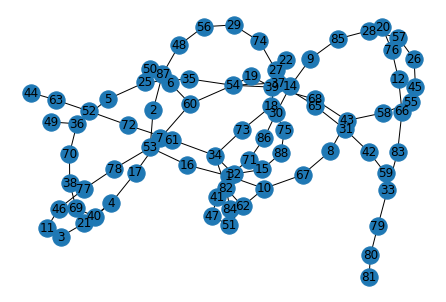

In [484]:
nx.draw(G, with_labels = True)

In [485]:
type(G)

networkx.classes.graph.Graph

## Add border nodes

In [486]:
input_nodes = pd.read_csv(os.path.join(inputFolder, "nodes.csv"))

In [487]:
input_nodes

,node_id,name,country,border,gauge_change,if_border_is_an_origin_or_destination
0,1,Aktau,KAZ,False,False,False
1,2,Aktobe,KAZ,False,False,False
2,3,Aktogal,KAZ,False,False,False
3,4,Almaty,KAZ,False,False,False
4,5,Andijan,UBZ,True,False,False
...,...,...,...,...,...,...
79,84,Rustawi,BORDER,True,False,False
80,85,Gomishan,IRA,True,True,False
81,86,No Name,UBZ,False,False,False
82,87,Yaysan,KAZ,True,False,False


## General methodology
Traversing through a border inqurs an additional cost. On top of this another additional cost is incurred is a gauge change occurs. The way these costs are modeled are by adding 1/2 the costs to each edge adjacent to each border node. This works because each path that traverses a border cost mus enter a border node and exit through a different edge.

### Pre-Processing for border nodes that are also an origin or destination node
(Insert Pic)

There are edge cases when a border node is also either an origin or destination (In this project it is never both). An example to illustrate why this is so; imagine a border node is also an origin. Then depending on what side of the border the border node is then the border cost may not occur at all if the next stop does not cross the border.

#### Add additional in-between nodes for edge cases for border nodes that are also an origin or destination node
(insert pic)
- For each border node that is also an origin or destination node
    - read which country the border node is in
        - For each edge adajent to the border node:
            If the from node is also in the same country:
                Add an extra node and split the edge

In [488]:
# loop through input nodes
for index, row in input_nodes.iterrows():
    # if border node and is either an origin or destination
    if row[5]:
        # country border node is in is row[2]
        print(row[0],row[1],row[2])
        for entry in list(G.neighbors(row[0])):
            print('adj node')
            #print(entry)
            print(G.nodes[entry])
            # add new intermediate node
            G.add_node(str(row[0])+'b')
            # add new edge from intermediate node to border node
            G.add_edge(str(row[0])+'b',row[0])
            # add new edge to connect to intermediate node instead of the border node
            G.add_edge(entry, str(row[0])+'b', cost=G.edges[entry,row[0]]['cost'] )
            # remove edge
            G.remove_edge(entry,row[0])
    # 

10 Baku AZE
adj node
{}
adj node
{}
adj node
{}
18 Brest BEL
adj node
{}
adj node
{}
adj node
{}
60 Tashkent UBZ
adj node
{}
adj node
{}
adj node
{}
68 Turkmenabad TKM
adj node
{}
adj node
{}


## We are not creating any intermediate nodes. Every shortest path that begins at a non-border node and passes through a border must cross an edge that goes into a border node and leaves a border node. Therefore we are just adding 1/2 the border costs to each adjacent edge to each border node.

## Later in the notebook we will add an additional 1/2 border costs to each shortest path that begins at a border node.

In [395]:
# border costs
# each border crossing has a time of 4 hours and a cost of $20 per ton
add_half_border_costs_per_link = (4 * value_of_time_per_ton_in_usd + 20) / 2
# each gauge change has a time of 12 hours and a cost of $10 per ton
add_half_border_w_gauge_costs_per_link = (12 * value_of_time_per_ton_in_usd + 10) / 2

In [396]:
border_nodes = []
border_nodes_w_gauge_change = []
# loop through input nodes
for index, row in input_nodes.iterrows():
    # if border node with gauge change
    if row[3]:
        border_nodes_w_gauge_change.append(row[0])
        border_nodes.append(row[0])
        for entry in list(G.neighbors(row[0])):
                #print('edge')
                #print(entry)
                G.edges[entry,row[0]]['cost'] = G.edges[entry,row[0]]['cost'] + add_half_border_w_gauge_costs_per_link + add_half_border_costs_per_link
    # else if reg border node
    elif row[2]:
        border_nodes.append(row[0])
        #print(row[0],row[1])
        for entry in list(G.neighbors(row[0])):
            #print('edge')
            #print(entry)
            G.edges[entry,row[0]]['cost'] = G.edges[entry,row[0]]['cost'] + add_half_border_costs_per_link

In [397]:
len(border_nodes)

21

In [398]:
len(border_nodes_w_gauge_change)

8

In [399]:
G.edges[5,36]

{'cost': 10.3902752}

In [400]:
G.edges[5,36]['cost'] = 2.9

In [401]:
G.edges[5,36]

{'cost': 2.9}

In [402]:
#G.edges[37,65]

In [403]:
#for e in G.edges(data = True):
    # For each edge's attribute
    #print(e)

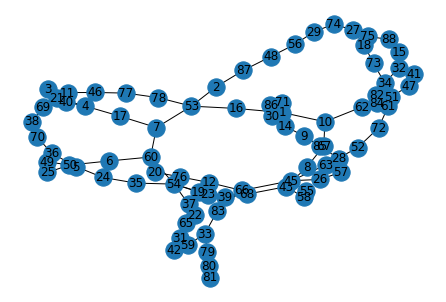

In [404]:
nx.draw(G, with_labels = True)

In [405]:
nodes_list = []
for n in G.nodes():
    nodes_list.append(n)

In [406]:
len(nodes_list)

85

In [407]:
import importlib
importlib.reload(gn)

<module 'GOSTnet' from '../../GOSTNets/GOSTNets/GOSTnet.py'>

In [408]:
# calculate OD matrix
import time
start = time.time()
OD_matrix = gn.calculate_OD(G, nodes_list, nodes_list, fail_value=-1, weight='cost')
end = time.time()
print(end-start)

0.08881115913391113


In [409]:
OD_matrix

array([[ 0.        ,  2.97613369, 16.21875413, ..., 62.59251618,
        65.23200898, 68.1981005 ],
       [ 2.97613369,  0.        , 19.19488782, ..., 59.61638249,
        62.25587529, 65.22196681],
       [16.21875413, 19.19488782,  0.        , ..., 72.36328496,
        75.00277776, 77.96886928],
       ...,
       [62.59251618, 59.61638249, 72.36328496, ...,  0.        ,
         2.6394928 ,  5.60558432],
       [65.23200898, 62.25587529, 75.00277776, ...,  2.6394928 ,
         0.        ,  2.96609152],
       [68.1981005 , 65.22196681, 77.96886928, ...,  5.60558432,
         2.96609152,  0.        ]])

In [410]:
OD_df = pd.DataFrame(OD_matrix, columns = nodes_list , index = nodes_list)

In [411]:
OD_df

,38,69,70,36,5,24,35,54,37,65,...,49,51,47,41,73,22,25,79,80,81
38,0.000000,2.976134,16.218754,29.983546,32.883546,41.152024,29.901970,29.634939,30.075099,30.899666,...,29.893167,72.015173,85.363323,97.047669,96.487785,30.923141,29.758771,62.592516,65.232009,68.198100
69,2.976134,0.000000,19.194888,27.007412,29.907412,38.175890,26.925836,26.658806,27.098966,27.923532,...,26.917033,69.039039,82.387190,94.071535,93.511652,27.947007,26.782637,59.616382,62.255875,65.221967
70,16.218754,19.194888,0.000000,16.885645,19.785645,40.422410,39.672739,39.405708,39.845868,40.670435,...,16.976025,88.233927,101.582078,113.266423,112.706540,40.693910,18.038865,72.363285,75.002778,77.968869
36,29.983546,27.007412,16.885645,0.000000,2.900000,23.536765,22.787093,22.520063,22.960223,23.784789,...,0.090380,85.962549,99.310700,110.995045,110.435162,23.808264,1.153219,55.477640,58.117132,61.083224
5,32.883546,29.907412,19.785645,2.900000,0.000000,20.636765,25.687093,25.420063,25.860223,26.684789,...,2.990380,88.862549,102.210700,113.895045,113.335162,26.708264,4.053219,58.377640,61.017132,63.983224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,30.923141,27.947007,40.693910,23.808264,26.708264,12.805286,1.555232,1.288202,0.848042,1.672608,...,23.717885,82.865143,96.213294,107.897639,108.408388,0.000000,23.583489,33.365458,36.004951,38.971043
25,29.758771,26.782637,18.038865,1.153219,4.053219,24.689984,22.562318,22.295288,22.735448,23.560014,...,1.062840,85.737774,99.085924,110.770270,110.210387,23.583489,0.000000,55.252864,57.892357,60.858449
79,62.592516,59.616382,72.363285,55.477640,58.377640,44.474662,33.224607,32.957577,32.517417,31.692850,...,55.387260,114.534518,108.555250,96.870904,90.653204,33.365458,55.252864,0.000000,2.639493,5.605584
80,65.232009,62.255875,75.002778,58.117132,61.017132,47.114154,35.864100,35.597070,35.156910,34.332343,...,58.026753,117.174011,111.194742,99.510397,93.292697,36.004951,57.892357,2.639493,0.000000,2.966092


In [412]:
# access costs are 0.17117 USD per ton
OD_df_w_extra_costs = OD_df + 0.17117

In [413]:
OD_df_w_extra_costs.loc[18]

38     79.025625
69     76.049491
70     95.244379
36     92.973001
5      95.873001
         ...    
22     93.912596
25     92.748226
79    108.457704
80    111.097197
81    114.063289
Name: 18, Length: 85, dtype: float64

In [414]:
border_nodes

[5,
 10,
 18,
 21,
 24,
 27,
 31,
 34,
 39,
 47,
 52,
 55,
 60,
 62,
 68,
 70,
 82,
 83,
 84,
 85,
 87]

In [415]:
add_half_border_costs_per_link

10.205408

In [416]:
OD_df_w_extra_costs.loc[border_nodes] = OD_df_w_extra_costs.loc[border_nodes] + add_half_border_costs_per_link

In [417]:
border_nodes_w_gauge_change

[18, 21, 55, 62, 70, 82, 83, 85]

In [418]:
add_half_border_w_gauge_costs_per_link

5.616224

In [419]:
OD_df_w_extra_costs.loc[border_nodes_w_gauge_change] = OD_df_w_extra_costs.loc[border_nodes_w_gauge_change] + add_half_border_w_gauge_costs_per_link

In [420]:
OD_df_w_extra_costs.loc[18]

38     94.847257
69     91.871123
70    111.066011
36    108.794633
5     111.694633
         ...    
22    109.734228
25    108.569858
79    124.279336
80    126.918829
81    129.884921
Name: 18, Length: 85, dtype: float64

In [421]:
OD_df_w_extra_costs.to_csv("asia_railways_output_OD_matrix.csv")

In [423]:
# Testing
nx.dijkstra_path_length(G, 26, 70, weight='cost')

65.65348911108828

In [424]:
nx.bidirectional_shortest_path(G, 26, 70)

[26, 45, 55, 58, 43, 68, 23, 54, 35, 24, 5, 36, 70]